In [3]:
import pandas as pd

In [4]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_kmeans(data, k, returns='labels', state=None):
  '''
  data:     n x m - matrix of input data (n observations, m features)
  k:        number of clusters
  returns:  'estimator' returns fitted estimator, 
            'labeled' returns labeled data matrix, 
            'labels' returns labels-array only (default)
  state:    random initialization (default 'None')
  '''

  estimator_fit = KMeans(n_clusters=k, random_state=state).fit(data)

  if returns == 'labels':
    return estimator_fit.labels_
  elif returns == 'labeled':
    return np.c_[data, estimator_fit.labels_]
  else:
    return estimator_fit

In [5]:
# Implementation by https://github.com/jqmviegas/jqm_cvi

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)

def dunn_fast(points, labels):
    """ Dunn index - FAST (using sklearn pairwise euclidean_distance function)
    
    Parameters
    ----------
    points : np.array
        np.array([N, p]) of all points
    labels: np.array
        np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di

import pandas as pd
from sklearn import metrics

def get_indices(data, labels):
  indices = pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])
      
  ch = metrics.calinski_harabasz_score(data, labels)
  db = metrics.davies_bouldin_score(data, labels)
  si = metrics.silhouette_score(data, labels)
  dn = dunn_fast(data, labels)

  indices = indices.append({'Calinski-Harabasz': ch,
                            'Davies-Bouldin': db,
                            'Silhouette': si,
                            'Dunn': dn}, 
                            ignore_index=True)

  return indices

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# list of tuples of (color, marker, label) for each possible cluster
clusters = [
  ('r', 'o', 0), 
  ('b', '^', 1), 
  ('g', 'x', 2), 
  ('m', '.', 3), 
  ('y', '*', 4), 
  ('c', '+', 5),
  ('maroon', '>', 6),
  ('lime', 'D', 7),
  ('gold', 'H', 8),
  ('indigo', '1', 9),
  ('aquamarine', 'v', 10),
]

def plot_tsne_2d(data, labels, title='', size=(12, 12), state=None, returns='plot'):
  '''
  data:     n x m matrix of data (n observations, m features)
  labels:   label array for all observations
  title:    title for the plot (default '')
  size:     size-tuple for the plot (width, height) in inches (default (12,12))
  state:    random initialization (default None)
  returns:  'plot' returns nothing and just plots
            'fig' returns figure object
  '''

  data_projected_2d = TSNE(n_components=2, random_state=state).fit_transform(data)

  labeled_data = np.c_[data_projected_2d, labels]

  fig = plt.figure(figsize=size)
  ax = fig.add_subplot(111)

  # number of clusters
  n = len(set(labels))

  # adds seperate scatter for each cluster 
  for color, marker, label in clusters[0:n]:
    current_cluster = labeled_data[labeled_data[:,-1] == label]

    ax.scatter(
      current_cluster[:, 0], 
      current_cluster[:, 1], 
      c=color, 
      marker=marker
    )

  ax.set_title(title)

  if returns == 'plot':
    plt.show()
  else:
    return fig


def plot_data_3d(
    data, 
    labels, 
    features=[0, 1, 2], 
    feature_names=['', '', ''], 
    title='', 
    size=(12, 12), 
    azimuth=-60 , 
    elevation=30 , 
    returns='plot'
  ):
  '''
  data:           n x m matrix of data (n observations, m features)
  labels:         label array for all observations
  features:       list of feature column indices (default first three)
  feature_names:  list of feature names (default '')
  title:          title for the plot (default '')
  size:           size-tuple for the plot (width, height) in inches (default (12,12))
  azimuth:        angle around z-axis (default -60)
  elevation:      elevation above 'ground plane' (default 30)
  returns:        'plot' returns nothing and just plots
                  'fig' returns figure object
  '''

  # seems somewhat redundant, but wanted to stay consistent with other functions
  labeled_data = np.c_[data, labels]

  fig = plt.figure(figsize=size)

  # number of clusters
  n = len(set(labels))

  ax = fig.add_subplot(111, projection='3d', azim=azimuth, elev=elevation)

  for color, marker, label in clusters[0:n]:
    current_cluster = labeled_data[labeled_data[:,-1] == label]

    ax.scatter(
      current_cluster[:, 0], 
      current_cluster[:, 1], 
      current_cluster[:, 2], 
      c=color, 
      marker=marker
    )

  ax.set_zlabel(feature_names[0])
  ax.set_ylabel(feature_names[1])
  ax.set_xlabel(feature_names[2])
  ax.set_title('')

  if returns == 'plot':
    plt.show()
  else:
    return fig

In [7]:
# LOAD DATA
seeds = pd.read_csv('data/seeds_dataset.txt', 
                    sep='\t', 
                    names=['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry_coeff', 'length_groove', 'label']
                   )

customers = pd.read_csv('data/Mall_Customers.csv')
customers.columns = ['id', 'gender', 'age', 'income', 'spending_score']
housing = pd.read_csv('data/Boston-house-price-data.csv')
redwine = pd.read_csv('data/winequality-red.csv')

In [11]:
seeds_test = cluster_kmeans(seeds[seeds.columns[:-1]], 3, returns='labeled', state=0)
customers_test = cluster_kmeans(customers[['gender', 'age', 'income', 'spending_score']], 3, returns='labeled', state=0)
housing_test = cluster_kmeans(housing, 3, returns='labeled', state=0)
redwine_test = cluster_kmeans(redwine, 3, returns='labeled', state=0)

In [9]:
customers.head()

id  gender  age  income  spending_score
0   1    Male   19      15              39
1   2    Male   21      15              81
2   3  Female   20      16               6
3   4  Female   23      16              77
4   5  Female   31      17              40

In [10]:
def bla(x):
    if x == 'Male':
        return 0
    else:
        return 1
    
customers['gender'] = customers['gender'].map(bla)

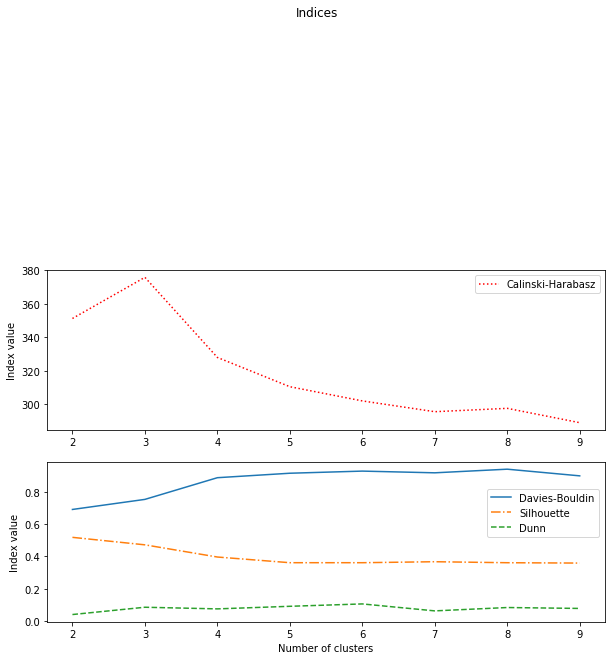

In [46]:
# seeds

indices_list = []
indices_df =  pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])

for k in range(2, 10):
    indices_list.append(get_indices(seeds[seeds.columns[:-1]], cluster_kmeans(seeds[seeds.columns[:-1]], k, returns='labels', state=0)))

indices = pd.concat(indices_list)

x = np.array([2,3,4,5,6,7,8,9])
Y = np.array(indices[['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn']])

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Indices')

ax = fig.add_subplot(3,1,2)
ax.plot(x, Y[:, 0], label='Calinski-Harabasz', color='r', linestyle='dotted', linewidth=1.5)
ax.legend()
ax.set_ylabel('Index value')

ax = fig.add_subplot(3,1,3)
ax.plot(x, Y[:, 1], label='Davies-Bouldin', linestyle='solid', linewidth=1.5)
ax.plot(x, Y[:, 2], label='Silhouette', linestyle='dashdot', linewidth=1.5)
ax.plot(x, Y[:, 3], label='Dunn', linestyle='dashed', linewidth=1.5)
ax.legend(bbox_to_anchor=(0.78,0.5))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Index value')

plt.show()

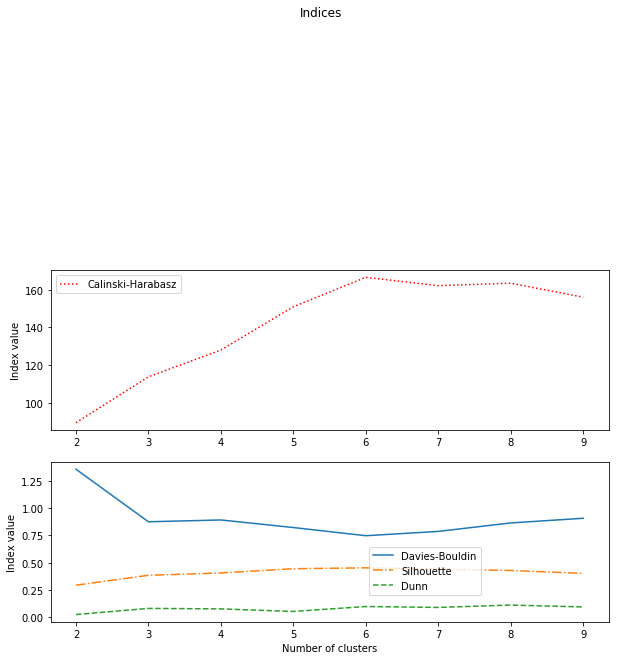

In [10]:
# mall customers

indices_list = []
indices_df =  pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])

for k in range(2, 10):
    a = cluster_kmeans(customers[['age', 'income', 'spending_score']], k, returns='labeled', state=0)
    indices_list.append(get_indices(a[:, :3], a[:, -1]))

indices = pd.concat(indices_list)

x = np.array([2,3,4,5,6,7,8,9])
Y = np.array(indices[['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn']])

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Indices')

ax = fig.add_subplot(3,1,2)
ax.plot(x, Y[:, 0], label='Calinski-Harabasz', color='r', linestyle='dotted', linewidth=1.5)
ax.legend()
ax.set_ylabel('Index value')

ax = fig.add_subplot(3,1,3)
ax.plot(x, Y[:, 1], label='Davies-Bouldin', linestyle='solid', linewidth=1.5)
ax.plot(x, Y[:, 2], label='Silhouette', linestyle='dashdot', linewidth=1.5)
ax.plot(x, Y[:, 3], label='Dunn', linestyle='dashed', linewidth=1.5)
ax.legend(bbox_to_anchor=(0.78,0.5))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Index value')

plt.show()

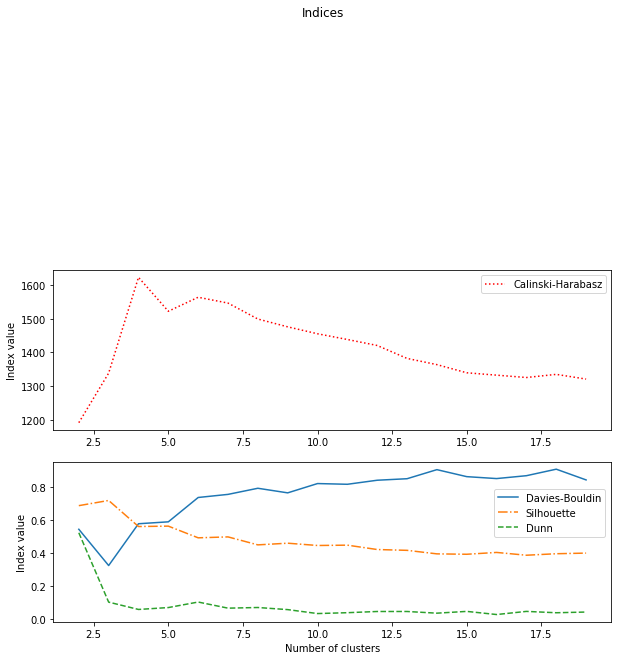

In [11]:
# housing

indices_list = []
indices_df =  pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])

for k in range(2, 20):
    a = cluster_kmeans(housing, k, returns='labels', state=0)
    indices_list.append(get_indices(housing, a))

indices = pd.concat(indices_list)

x = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
Y = np.array(indices[['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn']])

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Indices')

ax = fig.add_subplot(3,1,2)
ax.plot(x, Y[:, 0], label='Calinski-Harabasz', color='r', linestyle='dotted', linewidth=1.5)
ax.legend()
ax.set_ylabel('Index value')

ax = fig.add_subplot(3,1,3)
ax.plot(x, Y[:, 1], label='Davies-Bouldin', linestyle='solid', linewidth=1.5)
ax.plot(x, Y[:, 2], label='Silhouette', linestyle='dashdot', linewidth=1.5)
ax.plot(x, Y[:, 3], label='Dunn', linestyle='dashed', linewidth=1.5)
ax.legend(bbox_to_anchor=(0.78,0.5))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Index value')

plt.show()

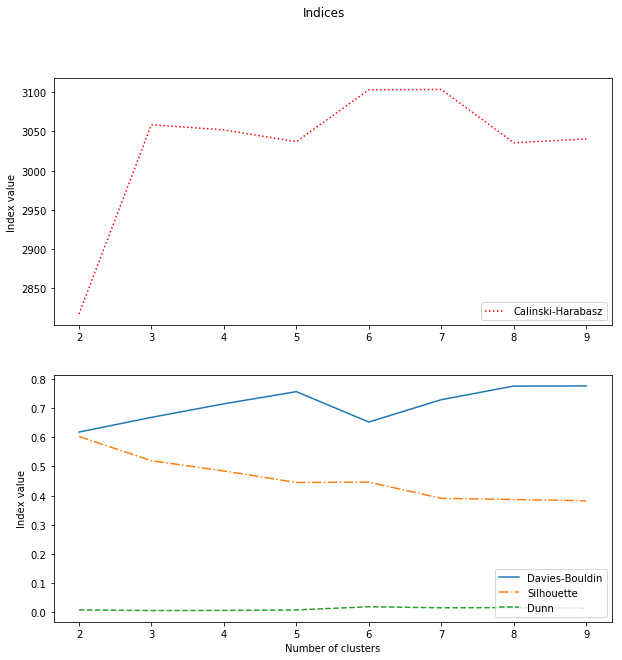

In [12]:
# redwine

indices_list = []
indices_df =  pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])

for k in range(2, 10):
    a = cluster_kmeans(redwine, k, returns='labels', state=0)
    indices_list.append(get_indices(redwine, a))

indices = pd.concat(indices_list)

x = np.array([2,3,4,5,6,7,8,9])
Y = np.array(indices[['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn']])

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Indices')

ax = fig.add_subplot(2,1,1)
ax.plot(x, Y[:, 0], label='Calinski-Harabasz', color='r', linestyle='dotted', linewidth=1.5)
ax.legend(loc=4)
ax.set_ylabel('Index value')

ax = fig.add_subplot(2,1,2)
ax.plot(x, Y[:, 1], label='Davies-Bouldin', linestyle='solid', linewidth=1.5)
ax.plot(x, Y[:, 2], label='Silhouette', linestyle='dashdot', linewidth=1.5)
ax.plot(x, Y[:, 3], label='Dunn', linestyle='dashed', linewidth=1.5)
#ax.legend(bbox_to_anchor=(1,0.5))
ax.legend(loc=4)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Index value')

plt.show()

In [10]:
d = [[1,2,3,4,5,6], [1,2,3,4,5,6]]
b = [1,2,3,4,5,6]

labeled_data = np.c_[a, b]

NameError: name 'a' is not defined

In [12]:
def get_all_indices(algorithm, data, parameter_range):
    '''
    algorithm:        the function performing clustering, taking data, one parameter
                      and only default parameters, returning list of labels
    data:             n x m matrix of data (n observations, m features)
    parameter_range:  list of values to iterate over
    '''

    indices_list = []
    indices_df =  pd.DataFrame(columns=['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn'])
    
    for p in parameter_range:
        try:
            indices_list.append(get_indices(data, algorithm(data, p, returns='labels')))
        except Exception:
            indices_list.append(pd.DataFrame(data={'Calinski-Harabasz': [0], 'Davies-Bouldin': [0], 'Silhouette': [0], 'Dunn': [0]}))
        
    indices_df = pd.concat(indices_list).reset_index(drop=True)
    indices_df['Parameter'] = parameter_range
        
    return indices_df

In [71]:
get_all_indices(cluster_meanshift, redwine[redwine.columns[:-1]], np.array([n for n in range(10, 40)])/1)

# K-Means - Wine

Calinski-Harabasz  Davies-Bouldin  Silhouette      Dunn  Parameter
0          873.209686        0.745061    0.318997  0.024688       10.0
1          694.500127        0.825069    0.406361  0.027242       11.0
2          837.432968        0.790453    0.430425  0.026971       12.0
3          822.783779        0.712859    0.427296  0.021930       13.0
4         1295.094719        0.620133    0.507274  0.027710       14.0
5         1346.443767        0.660763    0.524102  0.024689       15.0
6         1313.176320        0.656003    0.526792  0.031229       16.0
7         1280.246793        0.663480    0.528380  0.029248       17.0
8          656.125850        0.694582    0.478669  0.025793       18.0
9          777.949640        0.821218    0.548477  0.027625       19.0
10         785.266742        0.849142    0.521096  0.023929       20.0
11         730.595772        0.371520    0.596546  0.019807       21.0
12         725.381391        0.371205    0.596472  0.019807       22.0
13         704.267907        0.369602    0.596073  0.030197       23.0
14         696.180755        0.366919    0.596490  0.030197       24.0
15         691.804774        0.366030    0.596698  0.036131       25.0
16         686.017185        0.365594    0.596432  0.035228       26.0
17         123.467086        0.533387    0.745930  0.023289       27.0
18         123.467086        0.533387    0.745930  0.023289       28.0
19         123.467086        0.533387    0.745930  0.023289       29.0
20         115.358963        0.498870    0.768297  0.079312       30.0
21         115.358963        0.498870    0.768297  0.079312       31.0
22         115.358963        0.498870    0.768297  0.079312       32.0
23         115.358963        0.498870    0.768297  0.079312       33.0
24         115.358963        0.498870    0.768297  0.079312       34.0
25         115.358963        0.498870    0.768297  0.079312       35.0
26         115.358963        0.498870    0.768297  0.079312       36.0
27         115.358963        0.498870    0.768297  0.079312       37.0
28         115.358963        0.498870    0.768297  0.079312       38.0
29         115.358963        0.498870    0.768297  0.079312       39.0

In [100]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

get_all_indices(cluster_spectral, redwine[redwine.columns[:-1]], [n for n in range(2, 9)]) #seeds[seeds.columns[:-1]]

# K-Means - Wine

Calinski-Harabasz  Davies-Bouldin  Silhouette      Dunn  Parameter
0        2257.866178        0.678872    0.534338  0.004032          2
1        2531.999907        0.668309    0.447738  0.005227          3
2        2523.090367        0.709554    0.404143  0.004881          4
3        2475.956706        0.737619    0.368487  0.006838          5
4        2616.131644        0.793177    0.360221  0.006371          6
5        2458.377072        0.883971    0.349348  0.006371          7
6        2286.404310        0.887457    0.322394  0.004030          8

In [30]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

bla = get_all_indices(cluster_spectral, redwine[redwine.columns[:-1]], [n for n in range(2, 9)]) #seeds[seeds.columns[:-1]]

# K-Means - Wine

In [33]:
print(bla.round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Calinski-Harabasz &  Davies-Bouldin &  Silhouette &   Dunn &  Parameter \\
\midrule
0 &           2257.866 &           0.679 &       0.534 &  0.004 &          2 \\
1 &           2532.000 &           0.668 &       0.448 &  0.005 &          3 \\
2 &           2523.090 &           0.710 &       0.404 &  0.005 &          4 \\
3 &           2475.957 &           0.738 &       0.368 &  0.007 &          5 \\
4 &           2616.132 &           0.793 &       0.360 &  0.006 &          6 \\
5 &           2458.377 &           0.884 &       0.349 &  0.006 &          7 \\
6 &           2286.404 &           0.887 &       0.322 &  0.004 &          8 \\
\bottomrule
\end{tabular}



In [80]:
[n for n in range(-2, 14)]

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [13]:
[n for n in range(1,100,10)]

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]

In [25]:
def plot_indices(indices, title='Indices', parameter='Parameter', size=(10,7), returns='plot'):
    '''
    indices:      dataframe containing CH, DB, S, D index, Parameter (p x 5 matrix)
    title:        title for the plot (default '')
    parameter:    name of parameter
    size:         size-tuple for the plot (width, height) in inches (default (12,12))
    returns:      'plot' returns nothing and just plots
                'fig' returns figure object
    '''

    x = np.array(indices[['Parameter']])
    Y = np.array(indices[['Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette', 'Dunn']])

    fig = plt.figure(figsize=size)
    #fig.suptitle(title)

    linewidth = 1.5

    ax = fig.add_subplot(2,1,1)
    ax.plot(x, Y[:, 0], label='Calinski-Harabasz', color='r', linestyle='dotted', linewidth=linewidth)
    ax.legend(loc=4)
    ax.set_ylabel('Index value')
    ax.set_title(title)

    ax = fig.add_subplot(2,1,2)
    ax.plot(x, Y[:, 1], label='Davies-Bouldin', linestyle='solid', linewidth=linewidth)
    ax.plot(x, Y[:, 2], label='Silhouette', linestyle='dashdot', linewidth=linewidth)
    ax.plot(x, Y[:, 3], label='Dunn', linestyle='dashed', linewidth=linewidth)
    ax.legend(loc=4)
    ax.set_xlabel(parameter)
    ax.set_ylabel('Index value')
    
    fig.tight_layout()
    plt.savefig(title + '.pdf')

    if returns == 'plot':
        #plt.show()
        pass
    else:
        return fig

In [14]:
redwine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

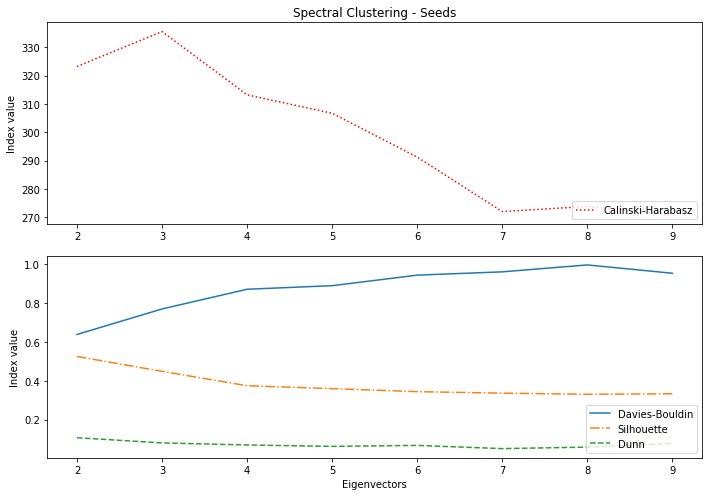

In [29]:
import warnings
warnings.filterwarnings('ignore')

plot_indices(
    get_all_indices(
        cluster_spectral, 
        seeds[seeds.columns[:-1]],
        [n for n in range(2, 10)]), 
    title='Spectral Clustering - Seeds', 
    parameter='Eigenvectors'
)

In [18]:
np.array([n for n in range(1, 31, 1)])/10

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [15]:
from sklearn.cluster import MeanShift
import numpy as np

def cluster_meanshift(data, bandwidth, returns='labels'):
  '''
  data:       n x m - matrix of input data (n observations, m features)
  bandwidth:  kernel's bandwidth or radius
  returns:    'estimator' returns fitted estimator, 
              'labeled' returns labeled data matrix, 
              'labels' returns labels-array only (default)
  '''

  estimator_fit = MeanShift(bandwidth=bandwidth).fit(data)

  if returns == 'labels':
    return estimator_fit.labels_
  elif returns == 'labeled':
    return np.c_[data, estimator_fit.labels_]
  else:
    return estimator_fit

In [16]:
from sklearn.cluster import AffinityPropagation
import numpy as np

def cluster_affinity(data, preference, returns='labels'):
  '''
  data:      panda dataframe
  preference:  numbers of exemplars 
  returns:    'labeled' returns labeled data matrix, 
              'labels' returns labels-array only (default)
  '''

  af = AffinityPropagation(preference=preference, verbose=False, max_iter=2000, random_state=0).fit(data)

  if returns == 'labels':
    return af.labels_
  elif returns == 'labeled':
    return np.c_[data, af.labels_]
  else:
    return af

In [17]:
from sklearn.cluster import SpectralClustering

def cluster_spectral(data, cluster_number, returns='labels'):
  '''
  data:      panda dataframe
  preference:  numbers of exemplars 
  returns:    'labeled' returns labeled data matrix, 
              'labels' returns labels-array only (default)
  '''

  sc = SpectralClustering(n_clusters=cluster_number, affinity='nearest_neighbors', n_init=100, random_state=0, n_jobs=-1).fit_predict(data)

  if returns == 'labels':
    return sc
  elif returns == 'labeled':
    return np.c_[data, sc.labels_]
  else:
    return sc

In [32]:
redwine.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
redwine_pca = pca.fit(redwine)

In [33]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
inds = get_all_indices(cluster_spectral, redwine[cols[:]], [n for n in range(2,15,1)]) 
inds
# Spectral Clustering - Wine

Calinski-Harabasz  Davies-Bouldin  Silhouette      Dunn  Parameter
0          120.956450        0.257014    0.743985  0.199888          2
1           93.017478        0.389372    0.718619  0.225191          3
2           71.355927        0.356027    0.644829  0.208533          4
3           64.054214        0.383927    0.555684  0.141232          5
4           53.841160        0.382063    0.463291  0.141232          6
5           50.299330        0.425625    0.449697  0.137426          7
6           60.159060        0.560321    0.432378  0.042989          8
7           52.319127        0.489573    0.432177  0.079781          9
8           52.547949        0.516652    0.405069  0.079781         10
9           48.001407        0.526391    0.402162  0.042989         11
10          43.700070        0.492747    0.402530  0.042989         12
11          41.699896        0.474456    0.400333  0.079781         13
12          48.693393        0.602343    0.282989  0.046191         14

In [ ]:
# Spectral Clustering - Housing

In [34]:
plot_indices(
    get_all_indices(
        cluster_affinity, 
        housing, 
        [n for n in range(-1000, 0, 50)]), 
    title='Affinity - Housing', 
    parameter='Preference'
)

KeyboardInterrupt: 

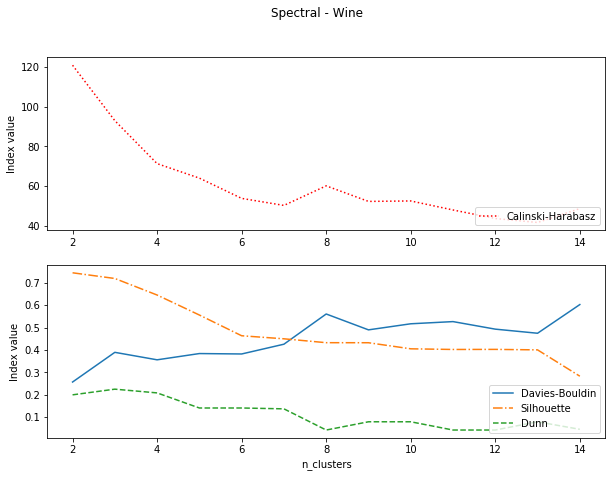

In [35]:
plot_indices(
    inds, 
    title='Spectral - Wine', 
    parameter='n_clusters'
)

In [116]:
"""A scikit learn compatible wrapper for clustering a data set without
specifying the number of clusters to generate.  Instead, the gap
statistic method is used to estimate the optimal number of clusters for
the data set."""

# Author: John Maloney
# License: BSD-3-Clause

import math
import numpy as np
from random import randint
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.exceptions import NotFittedError
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_array
from sklearn.utils import check_X_y
from sklearn.utils.validation import column_or_1d
from sklearn.utils.validation import check_is_fitted


class GapStatClustering(BaseEstimator, ClusterMixin, TransformerMixin):
    """A clusterer that uses the gap statistic to estimate the optimal
    number of clusters.
    For details on the gap statistic method for estimating the optimal
    number of clusters see [1]_.
    Parameters
    ----------
    base_clusterer : object or None, optional (default=None)
        The base clusterer to use to cluster the data.
        If None, then the base clusterer is K-Means.
    max_k : int, optional, default: 10
        The maximum number of clusters to consider when estimating the
        optimal number of clusters for the data set.
    B1 : int, optional, default: 10
        The number of null reference data sets that are generated and
        clustered in order to estimate the optimal number of clusters
        for the data set.
    B2 : int, optional, default: 1
        The number of times the input data set is clustered in order to
        estimate the average pooled with-in cluster sum of squares.  This
        can be used to improve the stability of the results.
    Attributes
    ----------
    n_clusters_ : int
        The estimate of the optimal number of clusters identified using
        the gap statistic method.
    labels_ :
        Labels of each point
    Examples
    --------
    >>> from gapstat import GapStatClustering
    >>> from sklearn.cluster import AgglomerativeClustering
    >>> from sklearn.datasets import make_blobs
    >>> X,_ = make_blobs(n_samples=16, centers=[[4,4],[-4,4],[-4,-4],[4,-4]],
    ...       n_features=2, random_state=2)
    >>>
    >>> gstat_km = GapStatClustering(max_k=5).fit(X)
    >>> gstat_km.n_clusters_
    4
    >>> gstat_km.labels_
    array([0, 0, 3, 1, 2, 0, 3, 2, 2, 1, 3, 0, 1, 2, 1, 3])
    >>> gstat_km.predict([[-3, -3], [3, 3]])
    array([4, 3], dtype=int32)
    >>>
    >>> gstat_ac = GapStatClustering(base_clusterer=AgglomerativeClustering(),
    ...                              max_k=5).fit(X)
    >>> gstat_ac.n_clusters_
    4
    >>> gstat_ac.labels_
    array([3, 3, 2, 0, 1, 3, 2, 1, 1, 0, 2, 3, 0, 1, 0, 2])
    References
    ----------
    .. [1] Tibshirani, R. , Walther, G. and Hastie, T. (2001), Estimating the
           number of clusters in a data set via the gap statistic. Journal of
           the Royal Statistical Society: Series B (Statistical Methodology),
           63: 411-423. doi:10.1111/1467-9868.00293
    """
    def __init__(self,
                 base_clusterer=None,
                 max_k=10,
                 B1=10,
                 B2=1):
        # create default base clusterer if necessary
        self.base_clusterer = _check_clusterer(base_clusterer)
        self.max_k = max_k
        self.B1 = B1
        self.B2 = B2

    def fit(self, X, y=None):
        """Compute the clustering.  The gap statistic method is used to estimate
        the optimal number of clusters.
        TO DO: allow optional fit parameters to be passed to the base clusterer
        Parameters
        ----------
        X : array-like, sparse matrix or dataframe,shape=[n_samples,n_features]
            The observations to cluster.
        y : Ignored
            not used, present here for API consistency by convention.
        Raises
        ------
        NotFittedError
            If the data set contains more clusters than k_max.
        """

        n_clusters, labels = \
            gapstat(X, clusterer=self.base_clusterer,
                    max_k=self.max_k, B1=self.B1, B2=self.B2)

        if ((n_clusters is None) | (labels is None)):
            msg = "The estimated optimal number of clusters is greater than " \
                    "max_k=%d"
            raise NotFittedError(msg % self.max_k)
        else:
            self.n_clusters_, self.labels_ = (n_clusters, labels)

        return self

    def fit_predict(self, X, y=None):
        """Compute the clustering and return the cluster label for each
        observation.
        Convenience method; equivalent to calling fit(X) followed by
        predict(X).
        TO DO: allow optional fit parameters to be passed to the base clusterer
        Parameters
        ----------
        X : array-like, sparse matrix or dataframe,shape=[n_samples,n_features]
            The observations to cluster.
        y : Ignored
            not used, present here for API consistency by convention.
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        Raises
        ------
        NotFittedError
            If the data set contains more clusters than k_max.
        """
        return self.fit(X).labels_

    def fit_transform(self, X, y=None):
        """Compute the clustering and transform X to cluster-distance space.
        Equivalent to fit(X).transform(X), but more efficiently implemented.
        If the base clusterer does not implement the trnsform() method then
        X is return untransformed.
        TO DO: allow optional fit parameters to be passed to the base clusterer
        Parameters
        ----------
        X : array-like, sparse matrix or dataframe,shape=[n_samples,n_features]
            New data to transform.
        y : Ignored
            not used, present here for API consistency by convention.
        Returns
        -------
        X_new : array, shape [n_samples, k]
            X transformed in the new space.
        Raises
        ------
        NotFittedError
            If the data set contains more clusters than k_max.
        AttributeError
            If the base_clusterer does not implement transform().
        """

        # make sure the base cluster implements transform()
        # -- raises AttributeError if it doesn't
        getattr(self.base_clusterer, 'transform')

        # fit the data and then call transform
        return self.fit(X).transform(X)

    def transform(self, X):
        """Transform X to a cluster-distance space.
        In the new space, each dimension is the distance to the cluster
        centers.  Note that even if X is sparse, the array returned by
        `transform` will typically be dense.
        If the base clusterer does not implement the trnsform() method then
        X is return untransformed.
        Parameters
        ----------
        X : array-like, sparse matrix or dataframe,shape=[n_samples,n_features]
            New data to transform.
        Returns
        -------
        X_new : array, shape [n_samples, k]
            X transformed in the new space.
        Raises
        ------
        NotFittedError
            If the estimator has not been fitted to a data set.
        AttributeError
            If the base_clusterer does not implement transform().
        """
        check_is_fitted(self)

        # call transform on the base clusterer
        return self.base_clusterer.transform(X)

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.
        Parameters
        ----------
        X : array-like, sparse matrix or dataframe,shape=[n_samples,n_features]
            New data to predict.
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        Raises
        ------
        NotFittedError
            If the estimator has not been fitted to a data set.
        AttributeError
            If the base_clusterer does not implement predict().
        """
        check_is_fitted(self)

        # call predict on the base clusterer
        return self.base_clusterer.predict(X)


def gapstat(X, clusterer=None, max_k=10, B1=10, B2=1, calcStats=False):
    """Gap statistic clustering algorithm.  Uses the gap statistic method
    to estimate the optimal number of clusters and uses that estimate
    to generate a clustering.
    TO DO: Provide a way to pass additionl parameters to the base clusterer.
    Parameters
    ----------
    X : array-like, sparse matrix or dataframe, shape (n_samples, n_features)
        The observations to cluster.
    clusterer : object or None, optional (default=None)
        The base clusterer to use to cluster the data.
        If None, then the base clusterer is K-Means.
    max_k : int, optional, default: 10
        The maximum number of clusters to consider when estimating the
        optimal number of clusters for the data set.
    B1 : int, optional, default: 10
        The number of null reference data sets that are generated and
        clustered in order to estimate the optimal number of clusters
        for the data set.
    B2 : int, optional, default: 1
        The numbe of times the input data set is clustered in order to
        estimate the average pooled with-in cluster sum of squares.  This
        can be used to improve the stability of the results.
    calcStats : boolean, optional, default: False
        Calculate and return the statistics for all values of k from
        1 through max_k.  The statistics include W, log(W), log(W*),
        gap and standard error.  Otherwise, stop when the estimated optimal
        k is determined and only return n_clusters and labels.
    Returns
    -------
    n_clusters : int
        The estimate of the optimal number of clusters identified using the
        gap statistic method.
    labels : int array, shape = [n_samples]
        The labels identifying the cluster that each sample belongs to.
        label[i] is the index of the cluster for the i-th observation.  The
        clustering includes n_clusters clusters.
    stats : dict, optional
        When calcStats is true, the statistics are returned in a dictionary
        with three entries: data, index and columns.  The data entry is a numpy
        two-dimensional array that includes the statistics described below.
        The index and columns entries provide additional information that can
        be used to create a pandas dataframe containing the statistics.  Each
        row of the data matrix provides the following statistics for each value
        of k considered:
        W : The mean pooled within-cluter sum of squares around the cluster
            means for the input data set.  The value returned for each value of
            k is the mean of B2 clusterings.
        log(W) : the logarithm of W (see above)
        log(W*) : The expectation of log(W) under an appropriate null reference
                  distribution of the data.  This is calculated as the mean log
                  pooled within-cluter sum of squares around the cluster means
                  for B2 generated null reference data sets.
        Gap : The gap statistic calculated as log(W*) - log(W).
        Std Err : The standard error of log(W*).
    Examples
    --------
    >>> from gapstat import gapstat
    >>> from sklearn.cluster import AgglomerativeClustering
    >>> from sklearn.datasets import make_blobs
    >>>
    >>> X,_ = make_blobs(n_samples=16, centers=[[4,4],[-4,4],[-4,-4],[4,-4]],
    ...       n_features=2, random_state=2)
    >>>
    >>> k, labels = gapstat(X, clusterer=AgglomerativeClustering(),
    ...                     max_k=5)
    >>> k
    4
    >>> labels
    array([3, 3, 2, 0, 1, 3, 2, 1, 1, 0, 2, 3, 0, 1, 0, 2])
    """
    # validate input parameters

    if max_k <= 0:  # TO DO: also check if it is an integer
        raise ValueError("Maximum number of clusters to consider should be "
                         "a positive integer, got %d instead" % max_k)

    if B1 <= 0:  # TO DO: also check if it is an integer
        raise ValueError("The number of null reference data sets to generate "
                         "should be a positive integer, got %d instead" % B1)

    if B2 <= 0:  # TO DO: also check if it is an integer
        raise ValueError("The number of times to cluster the data set to find "
                         "a stable W value should be a positive integer, got "
                         "%d instead" % B2)

    # check the clusterer and create a default clusterer if necessary
    clusterer = _check_clusterer(clusterer)

    # to determine whether a particular value of k is optimal
    # requires calculating the gap statistic for k+1, so
    # interate through all values of k up to max_k+1

    # check that the number of samples is consistent with (max_k+1)
    X, _, _ = _check_inputs(X=X, k=max_k+1)

    # create arrays to hold statistics
    # -- "pooled within-cluster sum of squares around cluster means"
    W = np.zeros(max_k+1)
    log_W = np.empty(max_k+1)
    log_W[:] = np.nan
    # -- "expected W_k under a null reference distribution of the data"
    log_W_star = np.empty(max_k+1)
    log_W_star[:] = np.nan
    # -- the gap statistic
    gap = np.empty(max_k+1)
    gap[:] = np.nan
    # -- standard error
    s = np.empty(max_k+1)
    s[:] = np.nan
    # -- labels for each value of k
    labels = np.full((max_k+1, X.shape[0]), -1)  # labels for each b
    # -- the estimated optimal number of clusters
    k_hat = None  # if max_k is too small then k_hat will be None

    for k in range(max_k+1):

        # calculate W and log(W)
        # -- k is zero-basd iterator, num clusters is one greater
        W[k], log_W[k], labels[k, :] = _calc_W(X, k+1,
                                               clusterer=clusterer, B=B2)

        # calculate log(W*) and the standard error
        # -- k is zero-basd iterator, num clusters is one greater
        log_W_star[k], s[k] = _calc_exp_W(X, k+1, clusterer=clusterer, B=B1)

        # calculate the gap statistic for k
        gap[k] = log_W_star[k] - log_W[k]
        # if W for ref data is less than W for input matrix
        # then set gap to zero and see if adding more clusters
        # reduces the value of W for the input matrix
        if (gap[k] < 0):
            gap[k] = 0

        # determine whether the previous value of k is the estimated optimal
        # number of clusters
        # -- (1) make sure the optimal has not been found
        # -- (2) make sure there is a previous value (k-1) for comparison
        # -- (3) make sure clustering of X is actually better than the
        # --     clustering of null ref data
        # -- (4) use gap statistic to determine if optimal k has been found
        if ((k_hat is None) &                    # (1)
                (k > 0) &                        # (2)
                (gap[k-1] != 0) &                # (3)
                (gap[k-1] >= (gap[k] - s[k]))):  # (4)

            # found an estimate of the optimal number of clusters!
            # -- # k is zero-based iteration index, num of clusters is +1
            k_hat = k  # previous value of k is the estimate: ((k-1)+1) = k

            # if we are not calculating statistics then stop
            if (not calcStats):
                break

    # -- end for k

    # fit the clusterer using the estimated optimal k &
    # identify labels for optimal k
    if (k_hat is not None):
        # fit the clusterer using k_hat as the number of clusters
        clusterer.set_params(n_clusters=k_hat)
        k_hat_labels = clusterer.fit_predict(X)
    else:
        k_hat_labels = None

    # return the results
    if (calcStats):
        stats = {}
        # create array of k values (index)
        stats["index"] = np.arange(1,max_k+2)
        # create an array of column headers (columns)
        stats["columns"] = np.array(["W", "log(W)", "log(W*)", "Gap", "Std Err"])
        # create a multi-dimensional array with the statistics (data)
        stats["data"] = np.stack((W, log_W, log_W_star, gap, s), axis=1)

        return k_hat, k_hat_labels, stats
    else:
        return k_hat, k_hat_labels

# end function


def gapstat_score(X, labels, k=None, clusterer=None, B=10, calcStats=False):
    """Compute the gap statistic score (metric) for the given clustering.
    The gap statistic is the difference between the log of the pooled
    within-cluster sum of squares for the candiate clustering and the
    expectation of that value under an apprpriate null reference
    distribution.
    For more details on the gap statistic see [1]_.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        The observations that were clustered.
    labels : array, shape = [n_samples]
        Predicted labels for each observation.
    k : int, optional, default: None
        The number of clusters in the clustering.  If set to None then the
        number of clusters will be calculated based on the supplied labels.
    clusterer : object or None, optional (default=None)
        The clusterer to use to cluster the null referece data sets.
        If None, then the base clusterer is K-Means.
    B : int, optional, default: 10
        The number of null reference data sets that are generated and
        clustered in order to estimate the optimal number of clusters
        for the data set.
    calcStats : boolean, optional, default: False
        Calculate and return the underlying statistics used to calculate
        the gap statistic score.  The statistics include W, log(W), log(W*),
        and standard error.  Otherwise, only the gap statistic score is
        returned.
    Returns
    -------
    gap : float
        The value of the gap statistic for the clustering.
    W : float, optional
        The mean pooled within-cluter sum of squares around the cluster means
        for the provided clustering.  This is only returned when calcStats is
        True.
    log_W : float, optional
        log(W).  This is only returned when calcStats is True.
    log_W_star : float, optional
        The expectation of log(W) under an appropriate null reference
        distribution of the data.  This is calculated as the mean log pooled
        within-cluter sum of squares around the cluster means for B generated
        null reference data sets.  This is only returned when calcStats is
        True.
    s : float, optional
        The standard error of log(W*).  This is only returned when calcStats
        is True.
    Examples
    --------
    >>> from gapstat import gapstat
    >>> from sklearn.cluster import AgglomerativeClustering
    >>> from sklearn.datasets import make_blobs
    >>>
    >>> X,_ = make_blobs(n_samples=16, centers=[[4,4],[-4,4],[-4,-4],[4,-4]],
    ...       n_features=2, random_state=2)
    >>>
    >>> ac = AgglomerativeClustering().fit(X)
    >>> gapstat_score(X, ac.labels_)
    -0.6028585939536981
    References
    ----------
    .. [1] Tibshirani, R. , Walther, G. and Hastie, T. (2001), Estimating the
           number of clusters in a data set via the gap statistic. Journal of
           the Royal Statistical Society: Series B (Statistical Methodology),
           63: 411-423. doi:10.1111/1467-9868.00293
    """
    if B <= 0:  # TO DO: also check if it is an integer
        raise ValueError("The number of null reference data sets to generate "
                         "should be a positive integer, got %d instead" % B)

    # check that the inputs are valid and consistent
    X, labels, k = _check_inputs(X=X, y=labels, k=k)

    # check the clusterer and create a default clusterer if necessary
    clusterer = _check_clusterer(clusterer)

    # calculate W for supplied clustering
    W = _pooled_within_cluster_sum_of_squares(X, labels, k)
    log_W = _safeLog(W)

    # calculate log(W*) and standard error
    log_W_star, s = _calc_exp_W(X, k, clusterer, B)

    # calculate the gap statistic for the clustering
    gap = log_W_star - log_W

    if (calcStats):
        return gap, W, log_W, log_W_star, s
    else:
        return gap


def _calc_W(X, k, clusterer=None, B=1):
    """Calculate the expected pooled within-in cluster sum of squares
    for the data set and the specified number of clusters k.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        The observations that were clustered.
    k : int
        The number of clusters to use when clustering the data sets.
    clusterer : object or None, optional (default=None)
        The clusterer to use to cluster the data set.  If None, then
        the clusterer is K-Means.
    B : int, optional, default: 10
        The number of times the data set should be clustered in order to
        determine an average pooled within cluster sum of squares.  This
        helps smooth out random differences introduced by random starting
        states for some clusterers.
    Returns
    -------
    W : float
        The mean pooled with-in cluster sum of squares for the B
        clusterings that were generated.
    log_W : float
        The mean log(W) for the B clusterings that were generated
    labels : array [n_samples]
        The mode of the labels generated for each of the B clusterings
        that were generated
    """

    # check the clusterer and create a default clusterer if necessary
    clusterer = _check_clusterer(clusterer)

    # handle degenerate case when there is 1 sample per cluster
    if (k == X.shape[0]):
        # return:
        # -- W: one sample per cluster, so W is zero
        # -- log(W): log(0) is undefined, return NaN
        # -- labels: return unique label for each sample
        return 0.0, np.nan, np.array(range(k))

    # cluster the data set B times and calculate the average W

    # arrays to hold stats for the B iterations
    W = np.zeros(B)
    log_W = np.empty(B)
    log_W[:] = np.nan
    labels = np.full((B, X.shape[0]), -1)  # labels for each b

    # set the number for clusters in the clustered data set
    clusterer.set_params(n_clusters=k)

    for b in range(B):
        # generate clusters
        labels[b, :] = clusterer.fit_predict(X)

        # calculate W and log(W) for the b-th iteration
        W[b] = _pooled_within_cluster_sum_of_squares(X, labels[b, :], k)
        log_W[b] = _safeLog(W[b])

    # -- end for b

    # find the mean of W and log(W) for the B clusterings
    avg_W = np.sum(W)/B
    avg_log_W = np.sum(log_W)/B

    # randomly select one of the clusterings to return
    i = randint(0, B-1)
    ret_labels = labels[i, :]

    return avg_W, avg_log_W, ret_labels


def _calc_exp_W(X, k, clusterer=None, B=10):
    """Calculate the expected pooled within-in cluster sum of squares
    for the null reference disribution for the data set and the
    specified number of clusters k.
    Parameters
    ----------
    X : array [n_samples, n_features]
        The observations that were clustered.
    k : int
        The number of clusters to use when clustering the null ref
        data sets.
    clusterer : object or None, optional (default=None)
        The clusterer to use to cluster the null referece data sets.
        If None, then the clusterer is K-Means.
    B : int, optional, default: 10
        The number of null reference data sets that are generated and
        clustered in order to calculate the null reference pooled within
        cluster sum of squares.
    Returns
    -------
    log_W_star : float
        The expected pooled within-in cluster sum of squares for the null
        reference disribution.
    std_err : float
        The standard error for the means of the B null reference data sets
    """

    # check the clusterer and create a default clusterer if necessary
    clusterer = _check_clusterer(clusterer)

    n_samples, n_features = X.shape

    # handle degenerate case when there is 1 sample per cluster
    if (k == n_samples):
        # return:
        # -- log(W*): W* is 0, log(0) is undefined, return NaN
        # -- standard error: return NaN
        return np.nan, np.nan

    # calculate min & max for samples
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    # generate B null ref sets, custer each set and calcualte the statistic

    # arrays to hold stats for the B null ref data sets for current k
    null_ref_W = np.zeros(B)  # value of W* for the B null ref sets
    log_null_ref_W = np.empty(B)  # value of log(W*) for the B null ref sets
    log_null_ref_W[:] = np.nan

    # set the number for clusters in the clustered data set
    clusterer.set_params(n_clusters=k)

    for b in range(B):
        # generate a new "null reference data set"
        null_ref = _gen_null_ref(n_samples, n_features, X_min, X_max)

        # generate clusters for the "null reference data set"
        labels = clusterer.fit_predict(null_ref)

        # calculate W* and log(W*) for the b-th null reference data set
        null_ref_W[b] = _pooled_within_cluster_sum_of_squares(null_ref,
                                                              labels, k)
        log_null_ref_W[b] = _safeLog(null_ref_W[b])

    # -- end for b

    # end generation and clustering of B null ref data sets

    # find the mean of log(W*) for the B ref data set samples
    log_W_star = np.sum(log_null_ref_W)/B  # log(W*) (aka, l_bar)

    # calculate the standard deviation
    sd = math.sqrt(np.mean(np.power(log_null_ref_W - log_W_star, 2)))

    # calculate the standard error
    s = sd*math.sqrt(1 + 1/B)

    return log_W_star, s


def _gen_null_ref(n_samples, n_features, f_min, f_max):
    """Generate a data set with the specified number of samples and
    values for features chosen from a uniform distributions with the
    specified minimum and maximum values.
    Parameters
    ----------
    n_samples : int
        The number of samples to generate.
    n_features : int
        The number of features to generate.
    f_min : arrray, float [n_features]
        The minimum values for the features.
    f_max : array, float [n_features]
        The maximum value for the features.
    Returns
    -------
    null_ref : array, float [ n_sample, n_features ]
        The generated samples.
    """

    # create 2D array to hold null reference data set
    null_ref = np.empty((n_samples, n_features))
    null_ref[:] = np.nan

    # generate a "null reference data set"
    for f in range(n_features):
        null_ref[:, f] = np.random.uniform(low=f_min[f], high=f_max[f],
                                           size=n_samples)
    # null ref set generated ---

    return null_ref


def _check_clusterer(clusterer=None):
    """Check that the clusterer is a valid clusterer (it implements
    the required methods).  If no cluster is provided, create
    a default clusterer.
    Parameters
    ----------
    clusterer : object or None, optional (default=None)
        The clusterer to use to cluster the data sets.
        If None, then the clusterer is K-Means.
    Returns
    -------
    clusterer : object
        The supplied clusterer or a default clusterer if none was provided.
    """

    if (clusterer is None):  # create default clusterer if necessary
        # default Cluster is KMeans
        clusterer = KMeans()
    else:
        # make sure base clusterer implements set_params()
        getattr(clusterer, 'set_params')

        # make sure base clusterer implements fit_predict()
        getattr(clusterer, 'fit_predict')

        # make sure base clusterer has n_clusters attribute
        getattr(clusterer, 'n_clusters')

    return clusterer


def _check_inputs(X=None, y=None, k=None):
    """Input validation for gapstat.
    Depending on the inputs provided, use one or more of the following
    validation utilities to validate the inputs:
        sklearn.utils.check_array()
        sklearn.utils.check_X_y()
        sklearn.utils.validation.column_or_1d()
    In addition, if k is provided, validate the following:
        0 < k <= X.shape[0]
        k == number of unique value in y
    Parameters
    ----------
    X : array [n_samples, n_features], optional
        The data set to be clustered
    y : array-like, shape=[n_samples], optional
        The labels identifying the cluster that each sample belongs to.
    k : int
        The number of clusters.
    Returns
    -------
    X_converted : object
        The converted and validated X.
    y_converted : object
        The converted and validated y.
    k_validated: int
        The calculated or validated k.
    """
    if (X is None) & (y is None):
        raise ValueError("One of 'X' or 'y' must not be 'None'")

    n_labels = None
    if (y is not None):
        le = LabelEncoder()
        y = le.fit_transform(y)
        n_labels = len(le.classes_)

    if (X is not None) & (y is not None):
        X, y = check_X_y(X, y)
        if (k is not None):
            if (not 0 < k <= X.shape[0]):
                raise ValueError("Number of clusters (k) is %d. Valid values "
                                 "are 1 to n_samples (inclusive)" % k)
            if (n_labels != k):
                raise ValueError("Number of unique labels (%d) does not equal "
                                 "the number of clusters (k=%d)."
                                 % (n_labels, k))
        else:  # (k is None)
            k = n_labels

    if (X is not None) & (y is None):
        X = check_array(X)
        if (k is not None) & (not 0 < k <= X.shape[0]):
            raise ValueError("Number of clusters (k) is %d. Valid values "
                             "are 1 to n_samples=%d (inclusive)"
                             % (k, X.shape[0]))

    if (X is None) & (y is not None):
        y = column_or_1d(y)
        if (k is not None) & (n_labels != k):
            raise ValueError("Number of unique labels (%d) does not equal the "
                             "number of clusters (k=%d)." % (n_labels, k))
        else:
            k = n_labels

    return X, y, k


def _pooled_within_cluster_sum_of_squares(X, labels, k):
    """Calculate the pooled within-cluster sum of squares (W) for
    the clustering defined by the specified labels.
    Parameters
    ----------
    X : array-like, sparse matrix or dataframe, shape=[n_samples, n_features]
        The observations that were clustered.
    labels : array-like, shape=[n_samples]
        The labels identifying the cluster that each sample belongs to.
    k: integer
        The number of unique labels - number of clusters.
    """
    n_samples, _ = X.shape

    # initialize W to zero
    W = 0

    # -- iterate over the clusters and calculate the pairwise distances for
    # -- the points
    for c_label in range(k):
        c_k = X[labels == c_label]
        d_k = euclidean_distances(c_k, c_k, squared=True)
        n_k = len(c_k)
        # multiply by 0.5 because each distance is included in the sum twice
        W = W + (0.5*d_k.sum())/(2*n_k)

    # return the result
    return W
# end pooled_within_cluster_sum_of_squares


def _safeLog(x):
    """Return the log of the specified number.  If the number
    is zero (or close to zero) return NaN.
    Parameters
    ==========
    x : float
    Returns
    =======
    log_x : float
        The value of log(x) or np.nan if x is zero.
    """
    if (math.isclose(x, 0.0)):
        # return a very small number
        return np.nan
    else:
        return math.log(x)


def _get_column_indices(X):
    """Get the column indices for the input matrix.  Determines the data
    type of the input matrix and uses the appropriate method to retrieve
    the column indices.
    """

    try:
        # this will fail if X is not a pandas DataFrame
        return list(X.columns)
    except AttributeError:
        pass

    # X is an array-like
    return list(range(X.shape[1]))
# -- end function

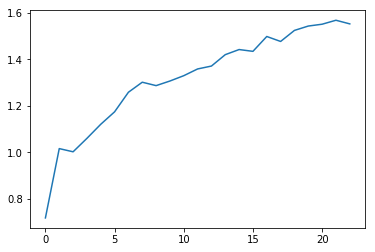

In [124]:
# gapstat_score(X, labels, k=None, clusterer=None, B=10, calcStats=False)

# seeds_test = cluster_kmeans(seeds[seeds.columns[:-1]], 3, returns='labeled', state=0)
# customers_test = cluster_kmeans(customers[['age', 'income', 'spending_score']], 3, returns='labeled', state=0)
# housing_test = cluster_kmeans(housing, 3, returns='labeled', state=0)
# redwine_test = cluster_kmeans(redwine, 3, returns='labeled', state=0)

dsfjkh = []
for i in range(2,25):
    seeds_kmeans_labels = cluster_kmeans(seeds[seeds.columns[:-1]], i, returns='labels', state=0)

    dsfjkh.append(gapstat_score(seeds[seeds.columns[:-1]], seeds_kmeans_labels))

plt.plot(dsfjkh)

In [130]:
redwine_test[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ,  5.    ,  1.    ])

In [131]:
redwine

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
5               7.4             0.660         0.00             1.8      0.075   
6               7.9             0.600         0.06             1.6      0.069   
7               7.3             0.650         0.00             1.2      0.065   
8               7.8             0.580         0.02             2.0      0.073   
9               7.5             0.500         0.36             6.1      0.071   
10              6.7             0.580         0.08             1.8      0.097   
11              7.5             0.500         0.36             6.1      0.071   
12              5.6             0.615         0.00             1.6      0.089   
13              7.8             0.610         0.29             1.6      0.114   
14              8.9             0.620         0.18             3.8      0.176   
15              8.9             0.620         0.19             3.9      0.170   
16              8.5             0.280         0.56             1.8      0.092   
17              8.1             0.560         0.28             1.7      0.368   
18              7.4             0.590         0.08             4.4      0.086   
19              7.9             0.320         0.51             1.8      0.341   
20              8.9             0.220         0.48             1.8      0.077   
21              7.6             0.390         0.31             2.3      0.082   
22              7.9             0.430         0.21             1.6      0.106   
23              8.5             0.490         0.11             2.3      0.084   
24              6.9             0.400         0.14             2.4      0.085   
25              6.3             0.390         0.16             1.4      0.080   
26              7.6             0.410         0.24             1.8      0.080   
27              7.9             0.430         0.21             1.6      0.106   
28              7.1             0.710         0.00             1.9      0.080   
29              7.8             0.645         0.00             2.0      0.082   
...             ...               ...          ...             ...        ...   
1569            6.2             0.510         0.14             1.9      0.056   
1570            6.4             0.360         0.53             2.2      0.230   
1571            6.4             0.380         0.14             2.2      0.038   
1572            7.3             0.690         0.32             2.2      0.069   
1573            6.0             0.580         0.20             2.4      0.075   
1574            5.6             0.310         0.78            13.9      0.074   
1575            7.5             0.520         0.40             2.2      0.060   
1576            8.0             0.300         0.63             1.6      0.081   
1577            6.2             0.700         0.15             5.1      0.076   
1578            6.8             0.670         0.15             1.8      0.118   
1579            6.2             0.560         0.09             1.7      0.053   
1580            7.4             0.350         0.33             2.4      0.068   
1581            6.2             0.560         0.09             1.7      0.053   
1582            6.1             0.715         0.10             2.6      0.053   
1583            6.2             0.460         0.29             2.1      0.074   
1584            6.7             0.320         0.44             2.4      0.061   
1585            7.2             0.390         0.44             2.6      0.066   
1586            7.5             0.310

In [150]:
pd.DataFrame(data={'Calinski-Harabasz': [0], 'Davies-Bouldin': [0], 'Silhouette': [0], 'Dunn': [0]})

Calinski-Harabasz  Davies-Bouldin  Silhouette  Dunn
0                  0               0           0     0